The first notebook to test the idea. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kgof
import kgof.data as data
import kgof.density as density
import kgof.goftest as gof
import kgof.kernel as kernel
import kgof.util as util
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Isotropic normal distribution

In [3]:
d = 1
mean = np.zeros(d)
variance = 5
isonorm = density.IsotropicNormal(mean, variance)

In [4]:
X = np.linspace(-8, 8, 200)[:, np.newaxis]
#X = np.random.randn(100, d)
dens = isonorm.log_den(X)
grads = isonorm.grad_log(X)

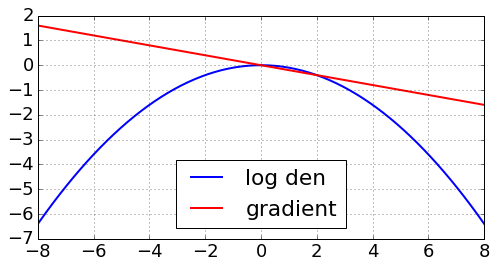

In [5]:
plt.figure(figsize=(8, 4))
plt.plot(X, dens, 'b-', label='log den')
plt.plot(X, grads, 'r-', label='gradient')
plt.grid()
plt.legend(loc='best')

In [6]:
# true p
seed = 20
d = 3
mean = np.zeros(d)
variance = 1
isonorm = density.IsotropicNormal(mean, variance)

In [7]:
# sample
n = 500

# only one dimension of the mean is shifted
#draw_mean = mean + np.hstack((1, np.zeros(d-1)))
draw_mean = mean +0
draw_variance = variance + 1
X = util.randn(n, d, seed=seed)*np.sqrt(draw_variance) + draw_mean
dat = data.Data(X)
tr, te = dat.split_tr_te(tr_proportion=0.5, seed=seed+1)

In [8]:
# Test
J = 5
alpha = 0.01

gwidth0 = util.meddistance(X, subsample=1000)**2
# random test locations
V0 = util.fit_gaussian_draw(X, J, seed=seed+1)

In [9]:
k0 = kernel.KGauss(gwidth0)
null_sim = gof.FSSDH0SimCovObs(n_simulate=1000, seed=10)

fssd = gof.FSSD(isonorm, k0, V0, null_sim=null_sim, alpha=alpha)
fssd.perform_test(te)

{'alpha': 0.01,
 'h0_rejected': False,
 'n_simulate': 1000,
 'pvalue': 0.014,
 'test_stat': 1.8783248384386237,
 'time_secs': 0.016670942306518555}

In [10]:
fssd.get_H1_mean_variance(te)

(0.0075132993537544946, 0.0075992813627589343)

----------------

## Optimized Gaussian FSSD

In [11]:
opts = {
    'reg': 1e-2,
    'max_iter': 50, 
    'tol_fun':1e-3, 
    'disp':True
}
V_opt, gw_opt, opt_result = gof.GaussFSSD.optimize_locs_widths(isonorm, tr, gwidth0, V0, **opts)

In [12]:
gw_opt

9.3710664323832731

In [13]:
# construct a test
k_opt = kernel.KGauss(gw_opt)
fssd_opt = gof.FSSD(isonorm, k_opt, V_opt, null_sim=null_sim, alpha=alpha)
fssd_opt_result = fssd_opt.perform_test(te, return_simulated_stats=True)
fssd_opt_result

{'alpha': 0.01,
 'h0_rejected': False,
 'n_simulate': 1000,
 'pvalue': 0.012999999999999999,
 'sim_stats': array([  1.25819640e-01,  -1.06483642e-01,   2.45671511e-01,
         -7.09300121e-01,  -2.25055694e-01,  -5.34730944e-01,
          1.08331513e-01,  -1.41494426e-02,  -6.55734943e-01,
          1.11377339e+00,  -1.24619345e-01,  -1.80378640e-01,
         -1.98003193e-01,   2.78249497e-01,   4.60343755e-01,
          4.81752370e-02,   5.31449176e-01,  -4.58845514e-01,
         -3.93926595e-02,   6.92274369e-01,   7.70769121e-01,
          1.79948045e-01,  -7.00413778e-01,   1.74741899e+00,
          1.97735098e-02,   1.89504576e-01,  -5.33987184e-01,
          1.76163171e+00,  -2.96824188e-01,  -4.54206701e-01,
         -6.15722902e-01,  -5.81425470e-01,   5.19764635e-01,
          5.03016797e-01,  -2.52364730e-01,   2.47613429e-01,
         -4.90548436e-01,  -5.94679519e-01,   2.90991110e-01,
         -4.00412513e-01,  -3.45567383e-01,  -4.47190115e-01,
         -1.88934408e-01, 

In [14]:
# get the mean and variance under H1 of the test statistic
fssd_opt.get_H1_mean_variance(te)

(0.0075377249139262758, 0.0074985002927684501)

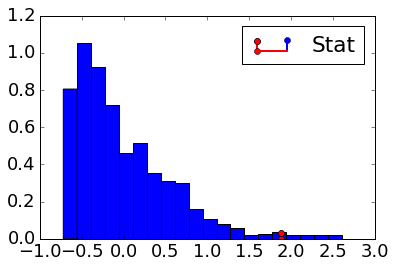

In [15]:
sim_stats = fssd_opt_result['sim_stats']
plt.hist(sim_stats, bins=20, normed=True);
plt.stem([fssd_opt_result['test_stat']], [0.03], 'r-o', label='Stat')
plt.legend()

In [16]:
gof.GaussFSSD.optimize_auto_init(isonorm, tr, J, **opts)

(array([[-0.48533073,  2.32664169, -0.79314006],
        [ 1.77239283, -0.93498154,  1.56803501],
        [ 0.70790149,  1.96197661, -1.19020806],
        [ 2.05575063,  0.38562135, -1.70363579],
        [ 1.62544016, -0.48553705,  1.95480837]]),
 4.4982134091392521,
 {'fun': -0.092712781297992403,
  'hess_inv': <16x16 LbfgsInvHessProduct with dtype=float64>,
  'jac': array([ -5.47959410e-05,  -3.28567821e-04,   4.11654599e-04,
          -3.73435422e-04,   1.26694162e-03,  -2.77768461e-04,
          -7.57575558e-04,  -1.66798167e-03,   4.63498212e-04,
           4.72176662e-04,   4.78349843e-04,  -2.90247167e-05,
          -5.20089178e-05,   5.62430520e-04,   4.58613924e-04,
          -3.95666878e-04]),
  'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'nfev': 15,
  'nit': 11,
  'status': 0,
  'success': True,
  'time_secs': 7.00511908531189,
  'x': array([ 2.1208992 , -0.48533073,  2.32664169, -0.79314006,  1.77239283,
         -0.93498154,  1.56803501,  0.70790149,  1